<a href="https://colab.research.google.com/github/tabowsy/NTU-MACHINE-LEARNING-2021-SPRING/blob/main/HW12_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

# INIT

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

import gym
import random
import numpy as np
from collections import namedtuple, deque

env = gym.make('LunarLander-v2')
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
fix(env, seed)
!pip freeze

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2,616 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,184 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-update

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
box2d-py==2.3.8
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
cftime==1.5.0
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.

In [ ]:
import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
env = gym.make('LunarLander-v2')
env.seed(543)
print('State shape: ', env.observation_space.shape)
print('Number of Actions: ', env.action_space.n)
torch.backends.cudnn.benchmark = False
import torch
torch.manual_seed(0)

State shape:  (8,)
Number of Actions:  4


# Model and Agent of DQL

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)



In [ ]:
# Define the DQN hyperparameters

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

# Use GPU is possible else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Training

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=3)

Episode 100	Average Score: -148.57
Episode 200	Average Score: -109.78
Episode 300	Average Score: -66.09
Episode 400	Average Score: 0.08
Episode 500	Average Score: 74.52
Episode 600	Average Score: 166.74
Episode 700	Average Score: 176.67
Episode 800	Average Score: 202.95
Episode 900	Average Score: 208.25
Episode 1000	Average Score: 226.95
Episode 1100	Average Score: 208.63
Episode 1200	Average Score: 185.32
Episode 1300	Average Score: 213.52
Episode 1400	Average Score: 234.52
Episode 1500	Average Score: 250.30
Episode 1600	Average Score: 243.27
Episode 1700	Average Score: 244.39
Episode 1800	Average Score: 239.61
Episode 1900	Average Score: 254.96
Episode 2000	Average Score: 242.67


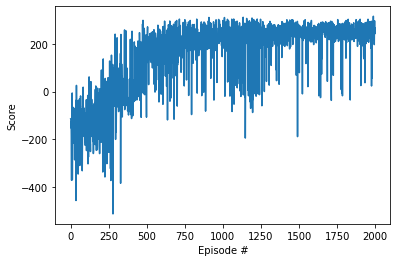

In [ ]:

torch.use_deterministic_algorithms(False)
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=260.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [ ]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

# Testing

In [ ]:
from pyglet.util import *
fix(env, seed)
NUM_OF_TEST = 5
test_total_reward = []
action_list = []

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.act(state).item()
        actions.append(action)
        env.render(mode="rgb_array")
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) #儲存你測試的結果
    print("length of actions is ", len(actions))

env.close()

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


239.6744618563592
length of actions is  264
204.33693362441613
length of actions is  337
144.0452648989875
length of actions is  1000
278.5289883150301
length of actions is  292
302.5094451035326
length of actions is  249


In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Your final reward is : 233.82
Action list looks like  [[1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 1, 2, 2, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
#download result
PATH = "Action_List_test.npy" 
np.save(PATH ,np.array(action_list)) 
from google.colab import files
files.download(PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#simulate judgeboi

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : 239.67
Your reward is : 204.34
Your reward is : 144.05
Your reward is : 278.53
Your reward is : 302.51
Your final reward is : 233.82


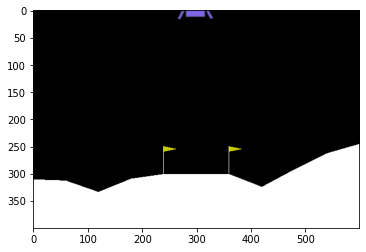

In [ ]:
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)


test_total_reward = []
for actions in action_list:
  state = env.reset()
  action = agent.act(state).item()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:
        
        break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

reference:\
https://github.com/iankgoode/DQN-for-LunarLander-v2/blob/master/dqn.ipynb